**Disclaimer:**
This notebook heavily relies on the paper [[1](#Sources)].
However, notations, results and interpretations may differ.

# **Clifford Quantum Cellular Automata**

A Clifford Quantum Cellular Automaton (CQCA) is a ruleset for mapping Pauli gates to a set of Pauli gates (or identity gates).
This globally unique ruleset is applied, at each time step, to every cell of an infinite lattice of cells.
Each cell holds either one of the Pauli gates or an identity gate.
The gates in this context are also referred to as Clifford operators.

The application of an operator to another follows following rules:
- $ i \times i = I, i \in \{I, X, Y, Z\} $ (Gates are unitary)
- $ i \times I = I \times i = i, i \in \{I, X, Y, Z\} $ (Identity is neutral)
- $ i \times j = k, i \neq j \neq k \in \{X, Y, Z\} $

Initially, all cells of the lattice hold identity gates.
However, one can change a finite number of the cells before the first iteration to form a starting configuration.
By then iterating over time steps, the configuration of the lattice changes.
The patterns in the change are discussed in this notebook.

Even though the dimensionality of the lattice does not matter in the context of CQCAs, it is easiest to consider only 1-dimensional lattices, i.e., spin chains.
Therefore the notebook only uses such spin chains.

## **Environment Preparation**
Technical necessities for the notebook to work properly.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from model.automaton import Automaton
from model.lattice import Lattice, plot_evolution, plot_entanglement
from model.gate import Identity, PauliX, PauliY, PauliZ

## **Rulesets**
Rules are specified by mapping quantum gates to a list of quantum gates.
For each cell, the corresponding rule is applied to the cell itself, as well as its neighborhood.

Mapping from an X gate:
First, a set of indices $ m_{X \rightarrow X} $ specifies the cells, which map to X gates, relative to the origin.
The next set $ m_{X \rightarrow Z} $ specifies the indices mapping to Z gates.

Mapping from a Z gate:
Analogously, there are two sets mapping Z to X and Z to Z gates.

In total, this yields the following matrix:

$
M =
\begin{pmatrix}
m_{X \rightarrow X} & m_{Z \rightarrow X} \\
m_{X \rightarrow Z} & m_{Z \rightarrow Z}
\end{pmatrix}
$

The mapping from a Y gate results from applying both an X and a Z gate (it also introduces a $1i$ coeffiecient, but it is of no importance here).

For example, the matrix
$
M_G =
\begin{pmatrix}
\{\} & \{0\} \\
\{0\} & \{-1, 1\}
\end{pmatrix}
$
represents the following ruleset:

$
X \rightarrow \underline{Z} \\
Y \rightarrow Z \underline{Y} Z \\
Z \rightarrow Z \underline{X} Z
$

This matrix represents the so called glider CQCA, the behavior of which is studied next.

## **Classes of CQCAs**

There are multiple classes of CQCAs:
- Glider CQCAs
- Fractal CQCAs
- Periodic CQCAs

### **Glider CQCAs**

In [3]:
glider = Automaton([[[], [0]], [[0], [-1, 1]]])

#### **Evolution of a Pauli Z Gate**
A cell containing a Z gate will contain an X gate in the next time step, and also apply a Z gate to the surrounding cells.

**Note:** Identity gates are not drawn explicitely.

In [4]:
plot_evolution(glider, [PauliZ()], 5)

          Z          
        Z X Z        
      Z X Z X Z      
    Z X Z X Z X Z    
  Z X Z X Z X Z X Z  
Z X Z X Z X Z X Z X Z


#### **Evolution of a Pauli X Gate**
An X gate will become a Z gate.
The neighborhood is unchanged.
From the second timestep forward the lattice behaves as if it had started with a Z gate.

In [5]:
plot_evolution(glider, [PauliX()], 5)

        X        
        Z        
      Z X Z      
    Z X Z X Z    
  Z X Z X Z X Z  
Z X Z X Z X Z X Z


Since quantum gates, especially Pauli gates, are unitary, they are able to cancel each other out into identity gates.
With the right configuration, the "active" gates (i.e., those, which are not the identity gates) propagate to a certain direction, leaving behind only "inactive" identity gates.

Starting with Pauli X and Z gates next to each other, the CQCA propagates the two gates one cell to the right with each time step, hence the name "glider".

In [6]:
plot_evolution(glider, [PauliX(), PauliZ()], 5)

X Z          
  X Z        
    X Z      
      X Z    
        X Z  
          X Z


Analogously, the two cells can also move to the left with a mirrored initial configuration.

In [7]:
plot_evolution(glider, [PauliZ(), PauliX()], 5)

          Z X
        Z X  
      Z X    
    Z X      
  Z X        
Z X          


### **Fractal CQCAs**

The following configuration demonstartes fractal behavior.

In [8]:
fractal = Automaton([[[-1, 0, 1], [0]], [[0], []]])

In [9]:
plot_evolution(fractal, [PauliX()], 25)

                                                  X                                                  
                                                X Y X                                                
                                              X Z Z Z X                                              
                                            X Y   X   Y X                                            
                                          X Z Y   Y   Y Z X                                          
                                        X Y X Z   Z   Z X Y X                                        
                                      X Z Z Z     X     Z Z Z X                                      
                                    X Y   X X   X Y X   X X   Y X                                    
                                  X Z Y   Z Z   Z Z Z   Z Z   Y Z X                                  
                                X Y X Z X X X   X X X   X X X Z X Y X             

With enough iterations (more than are feasible with the current visualization code) this CQCA evolves similar to the following figure (taken from [[1](#Sources)]):

![Fractal CQCA](images/fractal.png)

### **Periodic CQCAs**

Lastly, there are periodic CQCAs.
This means that after a certain step, the configuration returns to itself after a finite amount of time steps.

In [10]:
periodic = Automaton([[[0], []], [[-1, 1], [0]]])

In [11]:
plot_evolution(periodic, [PauliX()], 5)

  X  
Z X Z
  X  
Z X Z
  X  
Z X Z


## **Quantum entanglement**

CQCAs are primarily designed with quantum systems in mind.
Therefore it is of great interest to look at one of the most important aspects of quantum systems: Quantum entanglement.

When the non-identity cells of the initial configuration are entangled, their "reach", which may be increasing over time, entangles further cells.
Entanglement is also destroyed, if a cell returns to an identity gate.

### **Translation invariant stabilizer states**

In order to fully understand the entanglement behavior of CQCAs, the concept of translation invariant stabilizer states has to be defined.

A translation invariant stabilizer state $ \omega $ (for 1-dimensional lattices) is a chain of quantum states (qubits), which, after the application of a set of Clifford operator chains, again results in the same state.
In the context of CQCAs, the set of Clifford operator chains are the so called generators $ \mathbb{S} =\{(\cdots I_{i-1} Z_i I_{i+1} \cdots), \forall i \in \mathbb{Z}\} $.

The most important aspects are:
1. For *every* such set of generators there exists a stabilizer state
2. The application of a CQCA results in a different set of operator chains, which, in turn have their own stabilizer state

### **Bipartite cuts**

Entanglement is measured with respect to bipartite cuts of stabilizer states.
The entanglement $ E(t) $ is the number of entangled qubit pairs relative to any bipartite cut, at time $ t $.

Albeit all generators of the infinite set $ \mathbb{S} $ are considered at once, the problem can be reduced to a finite amount of computation steps.

### **Entanglement measurement**

The key to the solution to this seemingly infinite problem is the fact, that at any time, only a finite amount of cells are non-identity operators.
This implies that only a finite amount of cells can be entangled.
Therefore, one can iterate over all non-identity cells, and measure the number of cells entangled with them, and to which side of the cut they belong.
This yields $ E(t) $.

But how to determine, to which side of the cut an entangled cell belongs?
This is solved directly by the definition of $ \mathbb{S} $:
An arbitrary cut in $ \mathbb{S} $ already produces all possible cuts for a chain of cells.
Therefore it is sufficient to take the cell $ c_{max} $ with the most number of entanglements $ n_{max} $ an add $ 1 $ to it.
This yields the chain with the most entanglements.
The maximum number of entangled qubit pairs is then simply $ E(t) = \lfloor \frac{1}{2} (n_{max} + 1) \rfloor $.

The following shows the evolution of $ E(t) $ over time for the different kinds of CQCAs for the initial configuration $ (\cdots I Y X Y I \cdots) $:

In [12]:
alms = [
    (glider, "Glider", "v"),
    (fractal, "Fractal", "x"),
    (periodic, "Periodic", "s")
]
init_config = [PauliY(), PauliX(), PauliY()]

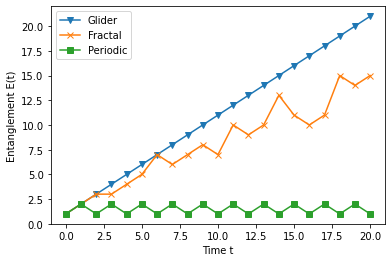

In [13]:
plot_entanglement(alms, init_config, 20)

Iterating the fractal CQCA further, the entanglement evolves as follows:

![Fractal entanglement](images/entanglement-fractal-150.png)

Alternatively, entanglement can also be measured with respect to tripartite cuts.
This, however, is out of the scope of this notebook.

# **Sources**

[1] Gütschow, Johannes. "Entanglement generation of Clifford quantum cellular automata." Applied Physics B 98.4 (2010): 623-633.